In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report,roc_auc_score, roc_curve)
from sklearn.model_selection import GridSearchCV

In [2]:
# loading datasets
train_df = pd.read_csv('fraudtrain.csv')
test_df = pd.read_csv('fraudtest.csv')
print("Successfully loaded fraudTrain.csv and fraudTest.csv")

Successfully loaded fraudTrain.csv and fraudTest.csv


In [3]:
# Data Exploration
print("\nTraining Data Info:")
print(train_df.info())
print("\nTest Data Info:")
print(test_df.info())


Training Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1296675 entries, 0 to 1296674
Data columns (total 23 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   Unnamed: 0             1296675 non-null  int64  
 1   trans_date_trans_time  1296675 non-null  object 
 2   cc_num                 1296675 non-null  int64  
 3   merchant               1296675 non-null  object 
 4   category               1296675 non-null  object 
 5   amt                    1296675 non-null  float64
 6   first                  1296675 non-null  object 
 7   last                   1296675 non-null  object 
 8   gender                 1296675 non-null  object 
 9   street                 1296675 non-null  object 
 10  city                   1296675 non-null  object 
 11  state                  1296675 non-null  object 
 12  zip                    1296675 non-null  int64  
 13  lat                    1296675 non-null  float64
 1

In [4]:
# Display class distribution
print("\nClass Distribution in Training Data:")
print(train_df['is_fraud'].value_counts())
print("\nClass Distribution in Test Data:")
print(test_df['is_fraud'].value_counts())


Class Distribution in Training Data:
is_fraud
0    1289169
1       7506
Name: count, dtype: int64

Class Distribution in Test Data:
is_fraud
0    553574
1      2145
Name: count, dtype: int64


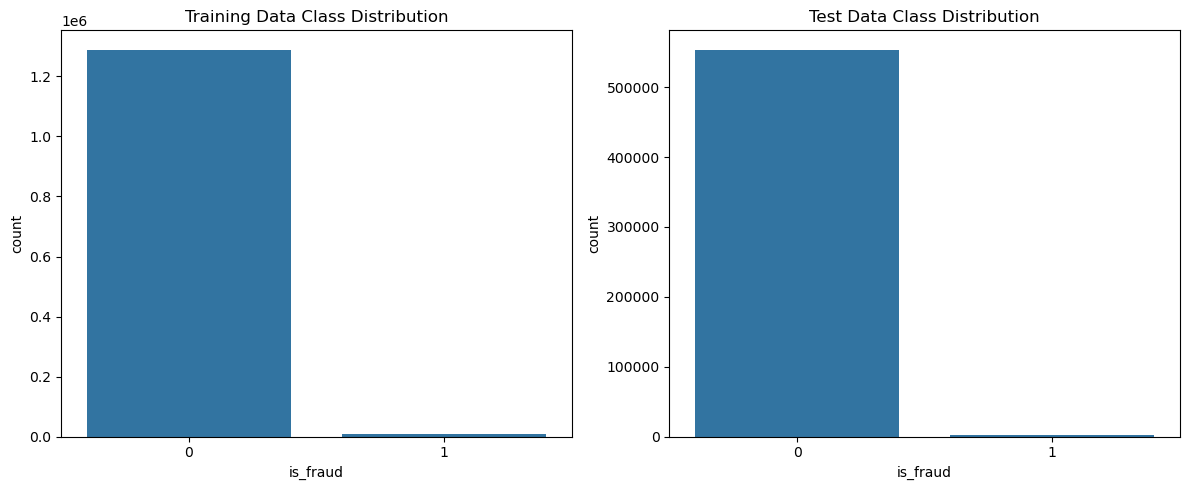

In [5]:
# Visualize class distribution
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.countplot(x='is_fraud', data=train_df)
plt.title('Training Data Class Distribution')
plt.subplot(1, 2, 2)
sns.countplot(x='is_fraud', data=test_df)
plt.title('Test Data Class Distribution')
plt.tight_layout()
plt.show()

In [6]:
# Data Preprocessing
def preprocess_data(df):
    # Convert categorical features
    categorical_cols = ['merchant', 'category', 'gender', 'city', 'state', 'job']
    for col in categorical_cols:
        if col in df.columns:
            le = LabelEncoder()
            df[col] = le.fit_transform(df[col].astype(str))
    
    # Convert datetime features
    if 'trans_date_trans_time' in df.columns:
        df['trans_date_trans_time'] = pd.to_datetime(df['trans_date_trans_time'])
        df['hour'] = df['trans_date_trans_time'].dt.hour
        df['day_of_week'] = df['trans_date_trans_time'].dt.dayofweek
        df['month'] = df['trans_date_trans_time'].dt.month
        df = df.drop('trans_date_trans_time', axis=1)
    
    if 'dob' in df.columns:
        df['dob'] = pd.to_datetime(df['dob'])
        df['age'] = (pd.to_datetime('today') - df['dob']).dt.days // 365
        df = df.drop('dob', axis=1)
    
    # Drop unnecessary columns
    cols_to_drop = ['Unnamed: 0', 'first', 'last', 'street', 'trans_num']
    for col in cols_to_drop:
        if col in df.columns:
            df = df.drop(col, axis=1)
    
    return df

In [7]:
# Preprocess both datasets
print("\nPreprocessing training data...")
train_df = preprocess_data(train_df)
print("\nDone")
print("\nPreprocessing test data...")
test_df = preprocess_data(test_df)
print("\nDone")


Preprocessing training data...

Done

Preprocessing test data...

Done


In [8]:
print("\nPreprocessed training data :")
train_df.head()


Preprocessed training data :


,cc_num,merchant,category,amt,gender,city,state,zip,lat,long,city_pop,job,unix_time,merch_lat,merch_long,is_fraud,hour,day_of_week,month,age
0,2703186189652095,514,8,4.97,0,526,27,28654,36.0788,-81.1781,3495,370,1325376018,36.011293,-82.048315,0,0,1,1,37
1,630423337322,241,4,107.23,0,612,47,99160,48.8878,-118.2105,149,428,1325376044,49.159047,-118.186462,0,0,1,1,47
2,38859492057661,390,0,220.11,1,468,13,83252,42.1808,-112.2620,4154,307,1325376051,43.150704,-112.154481,0,0,1,1,63
3,3534093764340240,360,2,45.00,1,84,26,59632,46.2306,-112.1138,1939,328,1325376076,47.034331,-112.561071,0,0,1,1,58
4,375534208663984,297,9,41.96,1,216,45,24433,38.4207,-79.4629,99,116,1325376186,38.674999,-78.632459,0,0,1,1,39


In [9]:
print("\nPreprocessed test data :")
test_df.head()


Preprocessed test data :


,cc_num,merchant,category,amt,gender,city,state,zip,lat,long,city_pop,job,unix_time,merch_lat,merch_long,is_fraud,hour,day_of_week,month,age
0,2291163933867244,319,10,2.86,1,157,39,29209,33.9659,-80.9355,333497,275,1371816865,33.986391,-81.200714,0,12,6,6,57
1,3573030041201292,591,10,29.84,0,16,43,84002,40.3207,-110.4360,302,392,1371816873,39.450498,-109.960431,0,12,6,6,35
2,3598215285024754,611,5,41.28,0,61,33,11710,40.6729,-73.5365,34496,259,1371816893,40.495810,-74.196111,0,12,6,6,54
3,3591919803438423,222,9,60.05,1,764,8,32780,28.5697,-80.8191,54767,407,1371816915,28.812398,-80.883061,0,12,6,6,37
4,3526826139003047,292,13,3.19,1,247,21,49632,44.2529,-85.0170,1126,196,1371816917,44.959148,-85.884734,0,12,6,6,70


In [10]:
# Separate features and target
X_train = train_df.drop('is_fraud', axis=1)
y_train = train_df['is_fraud']
X_test = test_df.drop('is_fraud', axis=1)
y_test = test_df['is_fraud']

In [11]:
# Scale numerical features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [12]:
# Handle class imbalance using SMOTE
from imblearn.over_sampling import SMOTE
print("\nBefore SMOTE:", pd.Series(y_train).value_counts())
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train_scaled, y_train)
print("After SMOTE:", pd.Series(y_train_res).value_counts())


Before SMOTE: is_fraud
0    1289169
1       7506
Name: count, dtype: int64


C:\Users\sumit\anaconda3\Lib\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(
C:\Users\sumit\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "C:\Users\sumit\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\sumit\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as pro

After SMOTE: is_fraud
0    1289169
1    1289169
Name: count, dtype: int64


In [13]:
# Model Training and Evaluation
def evaluate_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]
    
    metrics = {
        'accuracy': accuracy_score(y_test, y_pred),
        'precision': precision_score(y_test, y_pred),
        'recall': recall_score(y_test, y_pred),
        'f1': f1_score(y_test, y_pred),
        'roc_auc': roc_auc_score(y_test, y_prob),
        'confusion_matrix': confusion_matrix(y_test, y_pred),
        'report': classification_report(y_test, y_pred, digits=4)
    }
     # Plot confusion matrix
    plt.figure(figsize=(5, 4))
    sns.heatmap(metrics['confusion_matrix'], annot=True, fmt='d', 
                cmap='Blues', cbar=False)
    plt.title(f'{model.__class__.__name__} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    
    return metrics

In [14]:
# Initialize models with potential hyperparameters
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Decision Tree': DecisionTreeClassifier(max_depth=5, random_state=42),
}


Evaluating Logistic Regression...


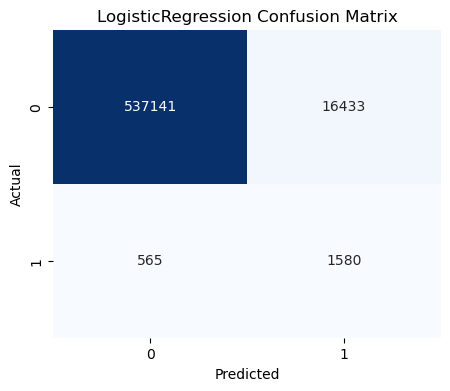


Logistic Regression Performance:
Accuracy: 0.9694
Precision: 0.0877
Recall: 0.7366
F1 Score: 0.1568
ROC AUC: 0.8512

Classification Report:
              precision    recall  f1-score   support

           0     0.9989    0.9703    0.9844    553574
           1     0.0877    0.7366    0.1568      2145

    accuracy                         0.9694    555719
   macro avg     0.5433    0.8535    0.5706    555719
weighted avg     0.9954    0.9694    0.9812    555719


Evaluating Decision Tree...


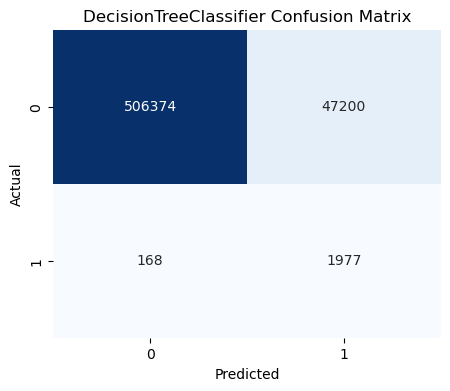


Decision Tree Performance:
Accuracy: 0.9148
Precision: 0.0402
Recall: 0.9217
F1 Score: 0.0770
ROC AUC: 0.9594

Classification Report:
              precision    recall  f1-score   support

           0     0.9997    0.9147    0.9553    553574
           1     0.0402    0.9217    0.0770      2145

    accuracy                         0.9148    555719
   macro avg     0.5199    0.9182    0.5162    555719
weighted avg     0.9960    0.9148    0.9519    555719



In [15]:
# Evaluate each model
results = {}
for name, model in models.items():
    print(f"\nEvaluating {name}...")
    results[name] = evaluate_model(model, X_train_res, y_train_res, X_test_scaled, y_test)
    
    # Print metrics
    print(f"\n{name} Performance:")
    print(f"Accuracy: {results[name]['accuracy']:.4f}")
    print(f"Precision: {results[name]['precision']:.4f}")
    print(f"Recall: {results[name]['recall']:.4f}")
    print(f"F1 Score: {results[name]['f1']:.4f}")
    print(f"ROC AUC: {results[name]['roc_auc']:.4f}")
    print("\nClassification Report:")
    print(results[name]['report'])

In [16]:
# Compare model performance
metrics_df = pd.DataFrame(results).T
print("\nModel Comparison:")
print(metrics_df[['accuracy', 'precision', 'recall', 'f1', 'roc_auc']])


Model Comparison:
                     accuracy precision    recall        f1   roc_auc
Logistic Regression  0.969413  0.087714  0.736597  0.156762  0.851216
Decision Tree        0.914763  0.040202  0.921678  0.077043  0.959375


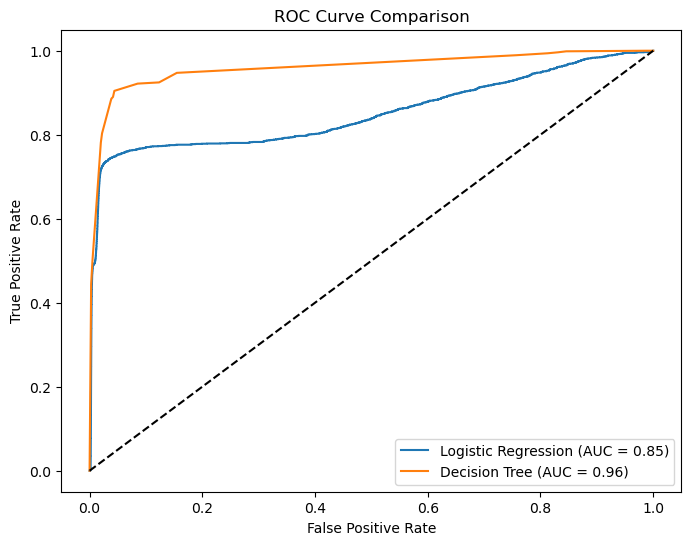

In [17]:
# Plot ROC curves
plt.figure(figsize=(8, 6))
for name, result in results.items():
    fpr, tpr, _ = roc_curve(y_test, models[name].predict_proba(X_test_scaled)[:, 1])
    plt.plot(fpr, tpr, label=f'{name} (AUC = {result["roc_auc"]:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison')
plt.legend()
plt.show()